In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('dataset/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
# Eliminamos las columnas que no vamos a utilizar usamos drop

df = df.drop(['selected_text'], axis=1)
df.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
df.isnull().sum()

textID       0
text         1
sentiment    0
dtype: int64

In [6]:
# Eliminamos los valores nulos

df = df.dropna()
df.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [7]:
# inicializamos el stemmer de Porter

stemmer = PorterStemmer()

# Tokenizamos y removemos palabras vacias y aplicar stemming

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if not word in stop_words]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

df['text'] = df['text'].apply(clean_text)

In [8]:
# Analizamos el sentimiento de los tweets

analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(text):
    score = analyzer.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1
    
df['sentimentLabel'] = df['text'].apply(sentiment_analyzer_scores)
df.head()

,textID,text,sentiment,sentimentLabel
0,cb774db0d1,"` respond , go",neutral,0
1,549e992a42,sooo sad miss san diego ! ! !,negative,-1
2,088c60f138,boss bulli ...,negative,0
3,9642c003ef,interview ! leav alon,negative,0
4,358bd9e861,"son * * * * , ` put releas alreadi bought",negative,0


In [9]:
df['sentimentLabel'].value_counts()

sentimentLabel
 1    12420
 0     9654
-1     5406
Name: count, dtype: int64

In [10]:
# Aquí es donde debes reasignar las etiquetas
df['sentimentLabel'] = df['sentimentLabel'].map({-1:0, 0:1, 1:2})
df.head()

,textID,text,sentiment,sentimentLabel
0,cb774db0d1,"` respond , go",neutral,1
1,549e992a42,sooo sad miss san diego ! ! !,negative,0
2,088c60f138,boss bulli ...,negative,1
3,9642c003ef,interview ! leav alon,negative,1
4,358bd9e861,"son * * * * , ` put releas alreadi bought",negative,1


In [11]:
X = df['text']
y = df['sentimentLabel']

# Dividimos el dataset en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

print('X_train: ', len(X_train))
print('X_test: ', len(X_test))

X_train:  21984
X_test:  5496


In [12]:
# Cargamos el tokenizer de BERT y el modelo pre-entrenado

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Ejemplo de tokenizacion

text = "This is a bert model tutorial"
tokens = tokenizer(text, max_length=128, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')

print('Texto original: ', text)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Texto original:  This is a bert model tutorial


In [13]:
# Tokenizacion

def tokenize_data(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='tf'
    )

X_train_encoded = [tokenize_data(text) for text in X_train]
X_test_encoded = [tokenize_data(text) for text in X_test]


# Extraemos los input_ids y las attention_masks de los datos tokenizados
train_input_ids = [encoded['input_ids'] for encoded in X_train_encoded]
train_attention_masks = [encoded['attention_mask'] for encoded in X_train_encoded]
test_input_ids = [encoded['input_ids'] for encoded in X_test_encoded]
test_attention_masks = [encoded['attention_mask'] for encoded in X_test_encoded]

# Ajustamos las dimensiones
train_input_ids = np.squeeze(np.array(train_input_ids))
train_attention_masks = np.squeeze(np.array(train_attention_masks))
test_input_ids = np.squeeze(np.array(test_input_ids))
test_attention_masks = np.squeeze(np.array(test_attention_masks))

In [14]:
# Configuramos el modelo Bert para que sea para 3 clases.

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3)

# Configuramos el modelo

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Definimos el modelo

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Entrenamos el modelo

history = model.fit([train_input_ids, train_attention_masks], y_train, 
          validation_data=([test_input_ids, test_attention_masks], y_test), 
          batch_size=32, 
          epochs=3)

Epoch 1/3
687/687 [==============================] - 5475s 8s/step - loss: 0.3502 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.1986 - val_sparse_categorical_accuracy: 0.9383
Epoch 2/3
687/687 [==============================] - 5152s 7s/step - loss: 0.1413 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.1478 - val_sparse_categorical_accuracy: 0.9558
Epoch 3/3
687/687 [==============================] - 8209s 12s/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.1513 - val_sparse_categorical_accuracy: 0.9574


In [18]:
# Evaluamos el modelo

model.evaluate([test_input_ids, test_attention_masks], y_test, batch_size=32)

172/172 [==============================] - 906s 5s/step - loss: 0.1513 - sparse_categorical_accuracy: 0.9574


[0.15125270187854767, 0.9574235677719116]

In [19]:
# Guardamos el modelo

model.save_pretrained('model')

In [20]:
# Ahora podemos cargar el modelo y usarlo para predecir

model = TFBertForSequenceClassification.from_pretrained('model')

Some layers from the model checkpoint at model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [21]:
# Predecimos

text = "This is a bert model tutorial"
tokens = tokenizer(text, max_length=128, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
output = model([input_ids, attention_mask])
prediction = tf.argmax(output[0], axis=1).numpy()[0]
print('Texto original: ', text)
print('Prediccion: ', prediction)

Texto original:  This is a bert model tutorial
Prediccion:  1


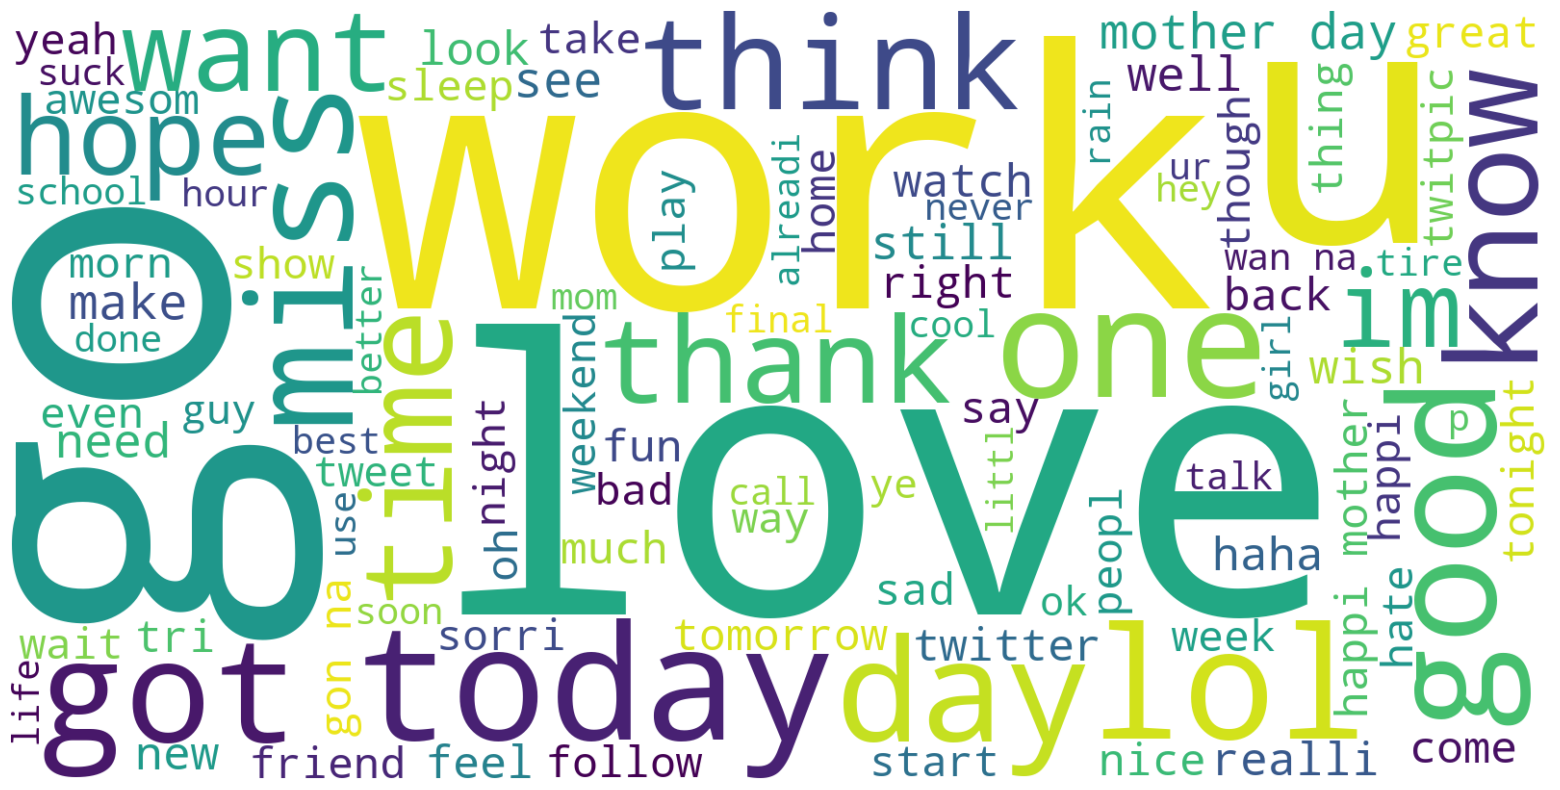

In [23]:
# juntamos todo el texto en un solo string

all_text = " ".join(text for text in df.text)

# generamos la nube de palabras

wordcloud = WordCloud(background_color="white", width=1600, height=800, random_state=37, max_words=100).generate(all_text)

# mostramos la nube de palabras

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

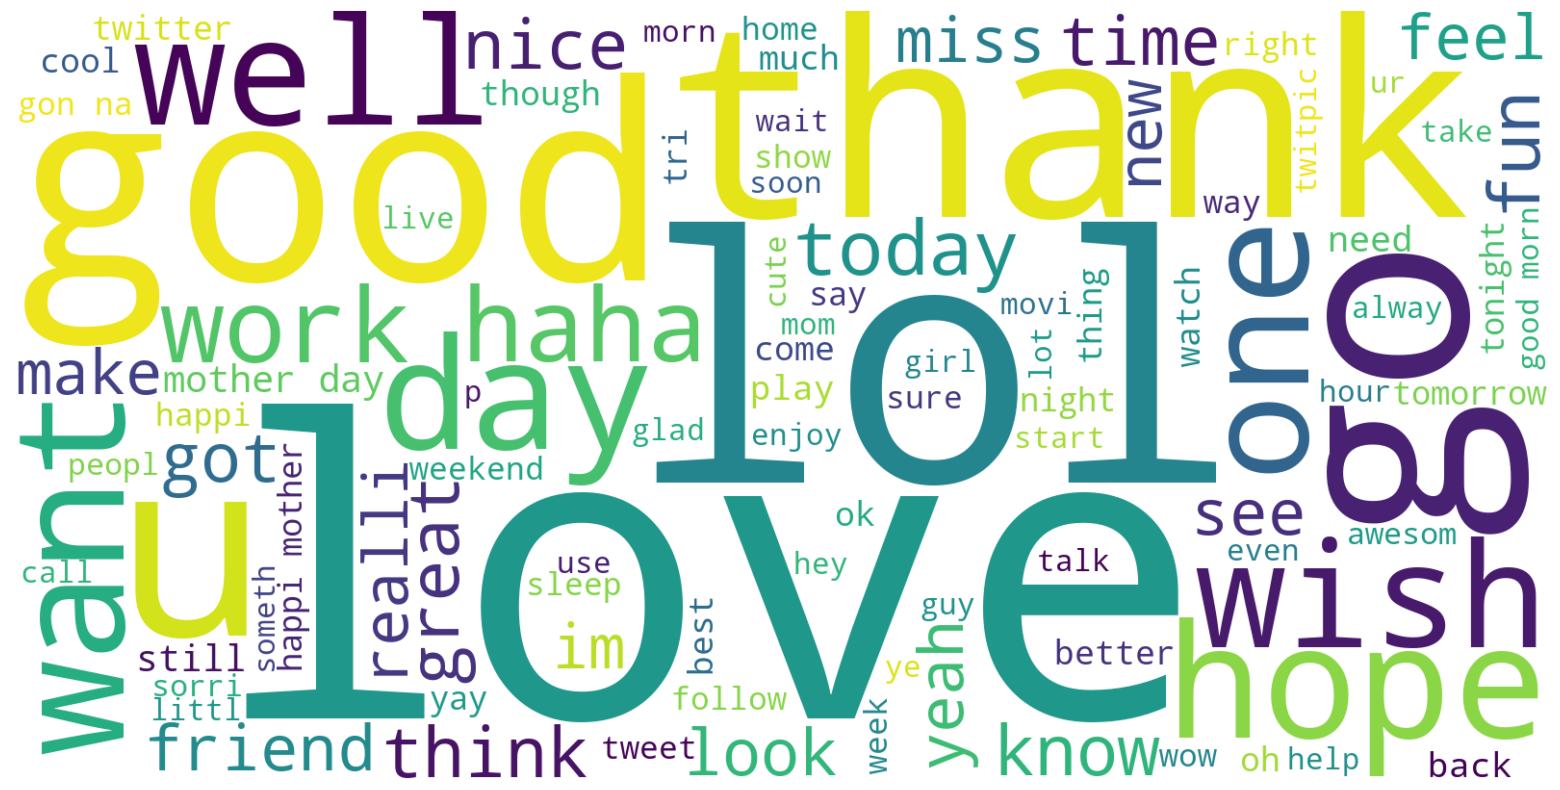

In [24]:
# Generamos la nube de palabras para los tweets positivos

all_text = " ".join(text for text in df[df['sentimentLabel']==2].text)

wordcloud = WordCloud(background_color="white", width=1600, height=800, random_state=37, max_words=100).generate(all_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

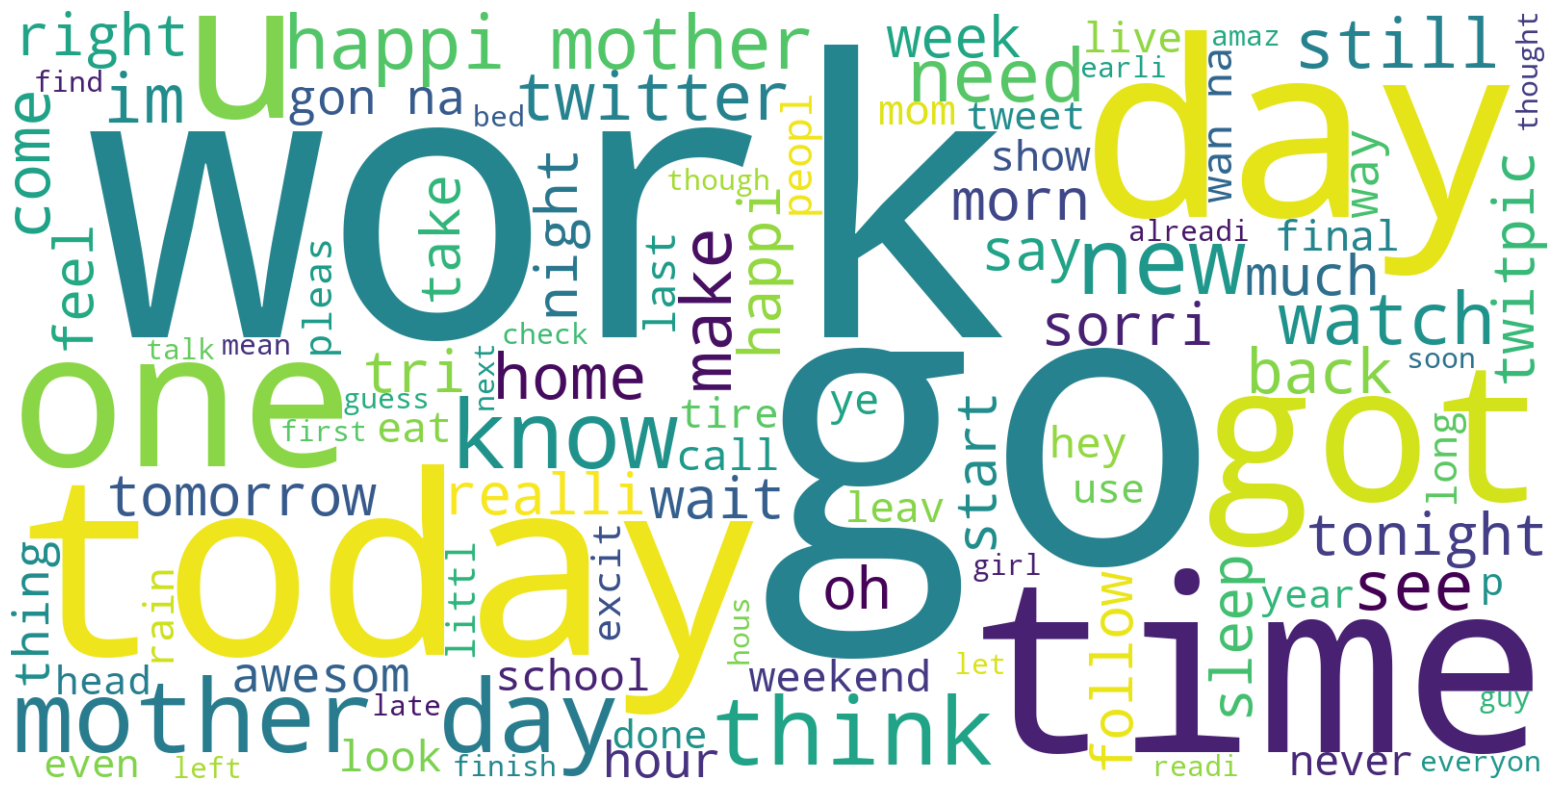

In [25]:
# Generamos la nube de palabras para los tweets neutrales

all_text = " ".join(text for text in df[df['sentimentLabel']==1].text)

wordcloud = WordCloud(background_color="white", width=1600, height=800, random_state=37, max_words=100).generate(all_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

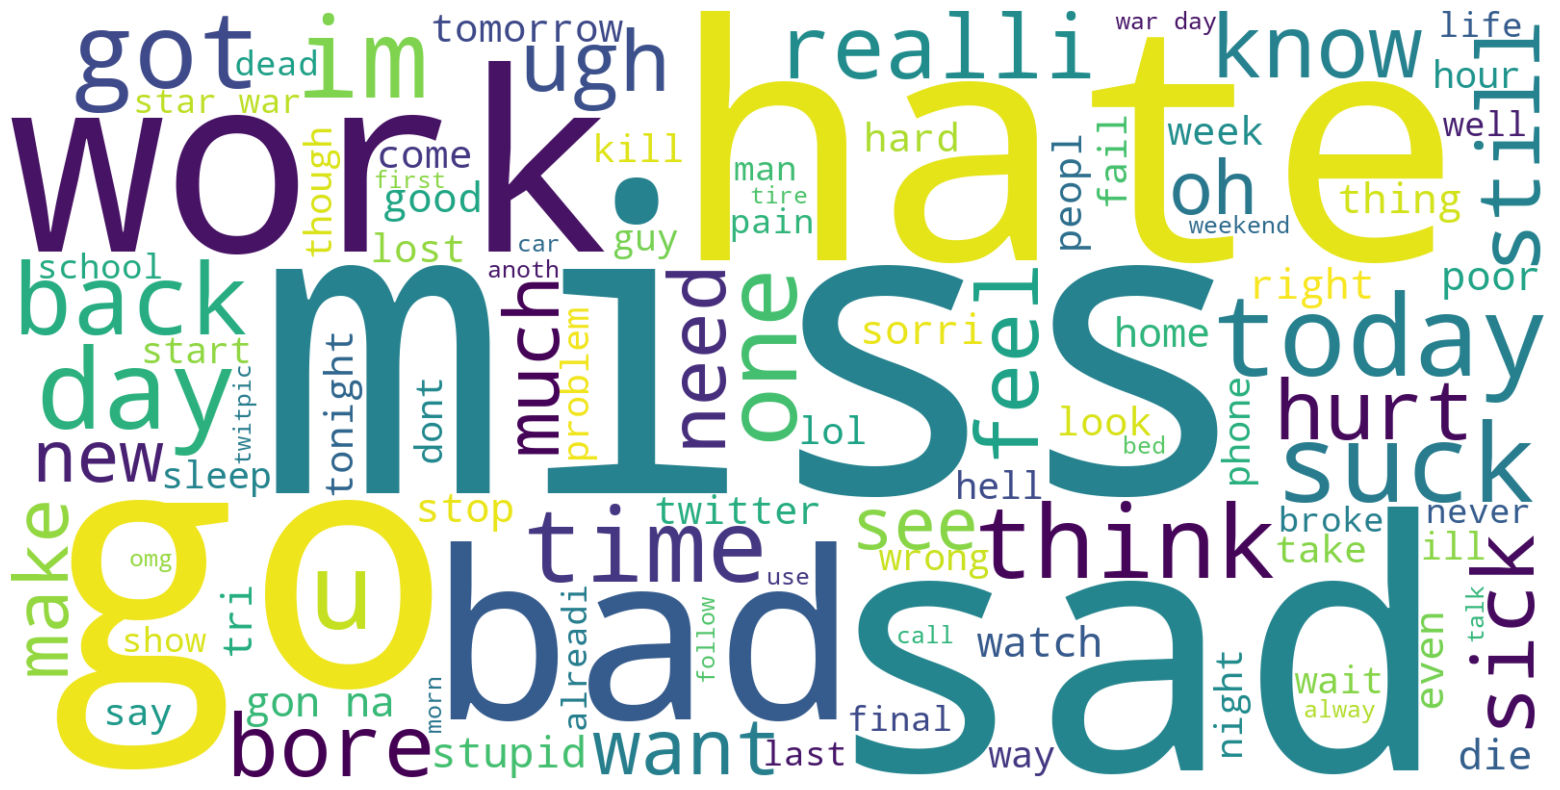

In [26]:
# Generamos la nube de palabras para los tweets negativos

all_text = " ".join(text for text in df[df['sentimentLabel']==0].text)

wordcloud = WordCloud(background_color="white", width=1600, height=800, random_state=37, max_words=100).generate(all_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()